<a href="https://colab.research.google.com/github/angelina-yang/test/blob/main/STORM_longform_writing_Claude_Contest_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
CLAUDE_API_KEY = 'sk-TAVILY_API_KEY = 'tvly-'

In [2]:
# !pip install litellm tavily-python anthropic
# !pip install fastembed typing qdrant_client

#**STORM: AI Agents for Long-Form Writing**

**Project Author: TwoSetAI**

**YouTube Channel:** https://www.youtube.com/@TwoSetAI



# **Project Motivation:**

Writing a well-structured and organized piece of content is crucial for effectively conveying information to readers. One of the key elements in achieving this is the use of top-down approach for writing, i.e, nailing down the outline before writing a single word. They provide a framework that guides the writer in presenting information in a logical and coherent manner.

In this project, we will explore an agentic system called STORM, which stands for **Synthesis of Topic Outlines through Retrieval and Multi-perspective Question Asking**.

This method is proposed by Stanford researchers and fully described in this paper "*[Assisting in Writing Wikipedia-like Articles From Scratch with Large Language Models](https://arxiv.org/pdf/2402.14207.pdf)*"

STORM is designed to assist in writing long-form articles by creating topic outlines, discovering diverse perspectives and simulating conversations with topic experts.

STORM can enhance the pre-writing stage, resulting in well-structured and comprehensive articles that rival those found on Wikipedia.

# **Project Scope:**
Due to time constraints, we implemented the method with Claude API in this notebook but didn't have time to implement a UI. We leverage the framework to write a test article on the following topic: *Building A Powerful LinkedIn Presence*.

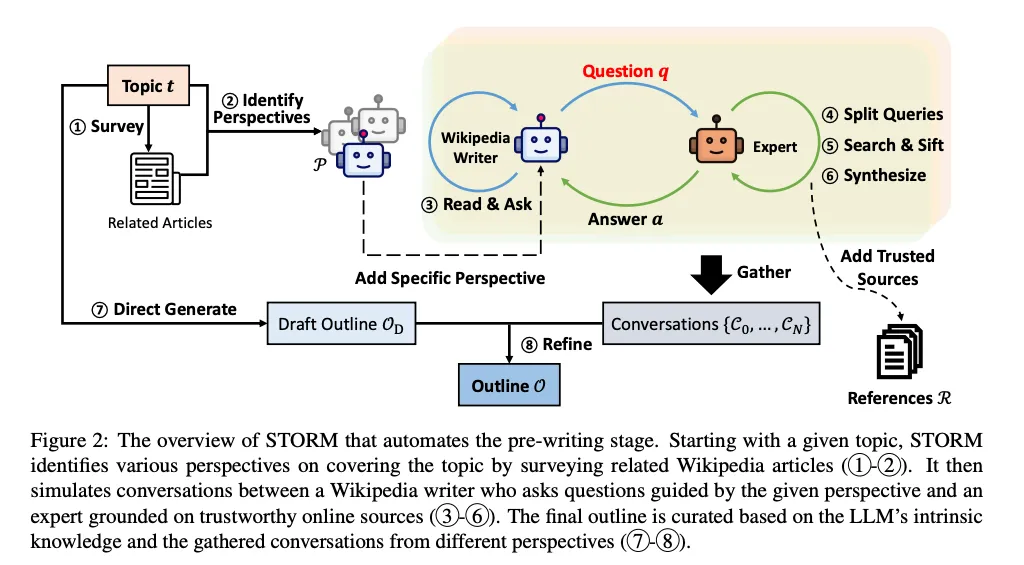

In [15]:
from litellm import completion, acompletion
import json
from tavily import TavilyClient
import anthropic
import json

tavily = TavilyClient(api_key=TAVILY_API_KEY)

In [16]:
def generate_related_topics(topic: str) -> list[str]:
    system_prompt = """I want to write a long-form article about a topic. I will give you the topic and I want you to suggest 3 related sub-topics to expand the content."""

    user_prompt = """Here's the topic:\n\nTOPIC:{topic}"""
    try:
        response = completion(
            api_key=CLAUDE_API_KEY,
            model="claude-3-opus-20240229",
            messages=[{"content": system_prompt, "role": "system"}, {"content": user_prompt.format(topic=topic), "role": "user"}],
            temperature=0.5,
            max_tokens=200,
        )
        response = response.choices[0].message.content
        # print(response)

        return response
    except Exception as e:
        print(f"Error in translation: {e}")


In [17]:
topic = 'Building A Powerful LinkedIn Presence'
related_topics = generate_related_topics(topic)
# related_topics = related_topics.split('\n')

In [18]:
related_topics_json = json.dumps(related_topics)
related_topics_json

'"Great topic! Here are three related sub-topics to help you expand the content of your article on \\"Building A Powerful LinkedIn Presence\\":\\n\\n1. Optimizing Your LinkedIn Profile\\n   - Crafting a compelling headline and summary\\n   - Choosing the right profile picture and background image\\n   - Highlighting your skills, experience, and achievements\\n   - Utilizing keywords to improve visibility and searchability\\n   - Requesting recommendations and endorsements\\n\\n2. Engaging and Networking on LinkedIn\\n   - Sharing valuable content and insights related to your industry\\n   - Commenting on and sharing others\' posts to increase visibility\\n   - Joining and actively participating in relevant LinkedIn groups\\n   - Connecting with professionals in your field and potential clients\\n   - Utilizing LinkedIn\'s messaging feature to build relationships\\n\\n3. Leveraging LinkedIn for Business Growth\\n   - Creating a LinkedIn Company Page to showcase your business\\n   - Deve

In [19]:
def generate_perspectives(topic: str, related_topics: str) -> list[str]:
    system_prompt = """You need to select a group of 3 writers who will work together to write a comprehensive article on the topic. Each of them represents a different perspective , role , or affiliation related to this topic .
    You can use other related topics for inspiration. For each role, add description of what they will focus on. Give your answer strictly in the following format without adding anything additional:1. short summary of writer one: description \n 2. short summary of writer two: description \n...\n\n"""

    user_prompt = """Here's the topic:\n\nTOPIC:{topic}\n\nRelated topics: {related_topics}"""
    try:

        response = completion(
            api_key = CLAUDE_API_KEY,
            model="claude-3-opus-20240229",
            messages=[{ "content": system_prompt,"role": "system"},{ "content": user_prompt.format(topic=topic, related_topics=related_topics),"role": "user"}],
            temperature=0.5,
            max_tokens=500,
        )
        response = response.choices[0].message.content
        print(response)
        return response
    except Exception as e:
        print(f"Error in translation: {e}")


In [20]:
perspectives = generate_perspectives(topic, related_topics)

1. LinkedIn Profile Optimization Expert: Focusing on crafting a compelling profile that showcases skills, experience, and achievements to attract potential employers or clients.
2. LinkedIn Networking Strategist: Concentrating on effective engagement tactics, such as sharing valuable content, participating in groups, and building relationships through connections and messaging.
3. LinkedIn Marketing Specialist: Exploring strategies for leveraging LinkedIn to promote businesses, such as creating company pages, developing targeted content, and utilizing LinkedIn ads and analytics.


In [21]:
perspectives = perspectives.split('\n\n')
perspectives

['1. LinkedIn Profile Optimization Expert: Focusing on crafting a compelling profile that showcases skills, experience, and achievements to attract potential employers or clients.\n2. LinkedIn Networking Strategist: Concentrating on effective engagement tactics, such as sharing valuable content, participating in groups, and building relationships through connections and messaging.\n3. LinkedIn Marketing Specialist: Exploring strategies for leveraging LinkedIn to promote businesses, such as creating company pages, developing targeted content, and utilizing LinkedIn ads and analytics.']

In [22]:
perspectives[0]

'1. LinkedIn Profile Optimization Expert: Focusing on crafting a compelling profile that showcases skills, experience, and achievements to attract potential employers or clients.\n2. LinkedIn Networking Strategist: Concentrating on effective engagement tactics, such as sharing valuable content, participating in groups, and building relationships through connections and messaging.\n3. LinkedIn Marketing Specialist: Exploring strategies for leveraging LinkedIn to promote businesses, such as creating company pages, developing targeted content, and utilizing LinkedIn ads and analytics.'

In [23]:
def generate_question(topic: str, perspective: str, history: list[str]):
    system_prompt = """You are an experienced writer and want to edit a long-form article about a given topic . Besides your identity as a writer, you have a specific focus when researching the topic .
Now , you are chatting with an expert to get information . Ask good questions to get more useful information .
Please ask no more than one question at a time and don 't ask what you have asked before. Other than generating the question, don't adding anything additional.
Your questions should be related to the topic you want to write.\n\nConversation history: {history}\n\n"""

    user_prompt = """Here's the topic:\n\nTOPIC:{topic}\n\nYour specific focus: {perspective}\n\nQuestion:"""

    context = "\n".join(history)
    try:

        response = completion(
            api_key = CLAUDE_API_KEY,
            model="claude-3-opus-20240229",
            messages=[{ "content": system_prompt.format(history=context),"role": "system"},{ "content": user_prompt.format(topic=topic, perspective=perspective),"role": "user"}],
            temperature=0.5,
            max_tokens=200,
        )
        response = response.choices[0].message.content
        # print(response)
        return response
    except Exception as e:
        print(f"Error in translation: {e}")



In [24]:
res = generate_question(topic, perspectives[0], [])
res

'What are some key elements to include in a LinkedIn profile to make it stand out and effectively showcase skills and experience?'

In [25]:
def generate_answer(topic: str, question: str, context: str):
    system_prompt = """You are an expert who can use information effectively . You are chatting with a
writer who wants to write an article on topic you know . You
have gathered the related information and will now use the information to form a response.
Make your response as informative as possible and make sure every sentence is supported by the gathered information.\n\nRelated information: {context}\n\n"""

    user_prompt = """Here's the topic:\n\nTOPIC:{topic}\n\nQuestion: {question}"""
    try:

        response = completion(
            api_key = CLAUDE_API_KEY,
            model="claude-3-opus-20240229",
            messages=[{ "content": system_prompt.format(context=context),"role": "system"},{ "content": user_prompt.format(topic=topic, question=question),"role": "user"}],
            temperature=0.5,
            max_tokens=600,
        )
        response = response.choices[0].message.content
        # print(response)
        return response
    except Exception as e:
        print(f"Error in translation: {e}")


In [26]:
all_conversations = []
references = []
duplicate_references = set()
total_questions = 3
for p in perspectives[:1]:
    history = []
    for i in range(total_questions):
        question = generate_question(topic, p, history)
        print(f"QUESTION: {question}")
        history.append(question)
        tavily_response = tavily.search(query=question)
        results = tavily_response['results']
        all_context = ""
        for result in results:
            all_context += result['content'] + "\n"
            if result['url'] in duplicate_references:
                continue
            duplicate_references.add(result['url'])
            references.append({"title": result['title'], "source": result['url'], "content": result['content']})
        # print(f"============\n{all_context}")
        answer = generate_answer(topic, question, all_context)
        # print(f"============\nANSWER: {answer}\n\n")
        history.append(answer)
    all_conversations.append(history)
print("DONE.")

QUESTION: What are the key elements of a well-optimized LinkedIn profile that helps attract potential employers or clients?
QUESTION: What are some effective ways to write a compelling LinkedIn headline that grabs the attention of potential employers or clients in my industry?
QUESTION: What are some best practices for writing an engaging and informative LinkedIn "About" section that effectively communicates my professional brand and value proposition to potential employers or clients?
DONE.


In [27]:
# for r in references:
#     print(r['title'])

# references

The Ultimate Guide To Crafting A LinkedIn Profile That ... - Forbes
Profile optimization on LinkedIn: the ultimate checklist
Optimizing Your LinkedIn Profile to Attract Employers
13 LinkedIn Profile Optimization Tips for Success in 2024
How To Optimize Your LinkedIn Profile for Success in 2024: A Step-by ...
How to Write Great LinkedIn Headlines (With 15 Examples)
How to Write the Perfect LinkedIn Headline (With Examples)
How to Write a Professional LinkedIn Headline - HubSpot Blog
18 Impactful LinkedIn Headline Examples from Real People - Jobscan
Optimize Your LinkedIn Headline: 20 Inspirational Examples
Your Job Seeker LinkedIn Summary: Best Practices for Writing an "About ...
10 Essential Tips for Writing Engaging LinkedIn Articles
Guide to LinkedIn Experience Section: Tips & Mistakes
Expert Tips to Build a Strong Executive LinkedIn Profile
How to Write a Catchy LinkedIn Headline: Best Practices


[{'title': 'The Ultimate Guide To Crafting A LinkedIn Profile That ... - Forbes',
  'source': 'https://www.forbes.com/sites/josephliu/2023/05/22/the-ultimate-guide-to-crafting-a-linkedin-profile-that-recruiters-love-advice-from-100-hiring-professionals/',
  'content': "“Since a LinkedIn profile is sometimes the recruiter's only source of information about a candidate, the more detail they provide in the Experience section, the better because it makes it easier to determine their suitability for the role at a glance. What types of certifications are worth mentioning?\nMention Relevant, Prerequisite Licenses Only\nIncluding licenses and certifications on your LinkedIn profile is a good way to showcase your professional credentials and highlight your skills and expertise according to Danielle Bedford, senior manager at Coople. “If a candidate has sufficient, relevant recent recommendations, it may even decrease due diligence time and the need for multiple reference checks,” says Waudby.\n

In [28]:
def generate_outline(topic: str) -> str:
    system_prompt = """Write an outline for an article about a given topic.
Here is the format of your writing:
Use "#" Title " to indicate section title , "##" Title " to indicate subsection title , "###" Title " to indicate subsubsection title , and so on.
Do not include other information.\n\n"""

    user_prompt = """Here's the topic:\n\nTOPIC:{topic}"""

    try:

        response = completion(
            api_key = CLAUDE_API_KEY,
            model="claude-3-opus-20240229",
            messages=[{ "content": system_prompt,"role": "system"},{ "content": user_prompt.format(topic=topic),"role": "user"}],
            temperature=0.5,
            max_tokens=500,
        )
        response = response.choices[0].message.content
        # print(response)
        return response
    except Exception as e:
        print(f"Error in translation: {e}")


In [29]:
outline = generate_outline(topic)

# Building A Powerful LinkedIn Presence

In [30]:
print(outline) #Claude

Here is an outline for an article on "Building A Powerful LinkedIn Presence":

# Why LinkedIn Matters for Your Career
## Networking Opportunities
## Establishing Credibility and Thought Leadership
## Attracting Job Opportunities

# Optimizing Your LinkedIn Profile
## Crafting a Compelling Headline 
## Writing an Engaging Summary
### Highlighting Key Accomplishments
### Showcasing Your Personality
## Selecting a Professional Profile Photo
## Detailing Your Work Experience
### Quantifying Achievements
### Using Action Verbs
## Listing Relevant Skills
## Seeking Recommendations

# Growing Your LinkedIn Network
## Connecting with Colleagues and Classmates
## Joining Relevant Groups
## Engaging with Others' Content
### Liking and Commenting
### Sharing Insightful Posts
## Leveraging Mutual Connections

# Sharing Valuable Content
## Posting Regular Status Updates
### Industry News and Trends
### Lessons Learned
### Personal Insights
## Publishing Long-Form Articles
### Demonstrating Expertis

In [31]:
def refine_outline(topic: str, outline: str, conversation: list[list[str]]) -> str:
    system_prompt = """I want you to improve an outline of an article about {topic} topic. You already have a draft outline given below that
covers the general information. Now you want to improve it based on the given
information learned from an information - seeking conversation to make it more
comprehensive. Here is the format of your writing:
Use "#" Title " to indicate section title , "##" Title " to indicate
subsection title , "###" Title " to indicate subsubsection title , and so on. Do not include other information.\n\ndraft outline: {outline}\n\n"""

    user_prompt = """learned information: {conversation}"""
    flattened_list = [item for sublist in conversation for item in sublist]
    context = ''.join(flattened_list)
    try:
        response = completion(
            api_key = CLAUDE_API_KEY,
            model="claude-3-opus-20240229",
            messages=[{ "content": system_prompt.format(topic=topic, outline=outline),"role": "system"},{ "content": user_prompt.format(conversation=context),"role": "user"}],
            temperature=0.5,
            max_tokens=800,
        )
        response = response.choices[0].message.content
        # print(response)
        return response
    except Exception as e:
        print(f"Error in translation: {e}")

In [ ]:
refined_outline = refine_outline(topic, outline, all_conversations)

In [33]:
print(refined_outline) #Claude

Here is an improved outline for an article on "Building A Powerful LinkedIn Presence" based on the provided information:

# Why LinkedIn Matters for Your Career
## Networking Opportunities
## Establishing Credibility and Thought Leadership
## Attracting Job Opportunities

# Optimizing Your LinkedIn Profile
## Crafting a Compelling Headline
### Highlighting Your Unique Value Proposition 
### Using Relevant Keywords
### Quantifying Your Achievements
### Showing Your Personality
### Testing Different Headlines
### Keeping it Concise
## Writing an Engaging About Section
### Grabbing Attention with a Strong Opening Line
### Clearly Articulating Your Unique Value Proposition
### Telling Your Professional Story
### Using Keywords 
### Adding Multimedia
### Including a Call-to-Action
### Proofreading and Refining
## Completing All Profile Sections Thoroughly
### Detailing Your Work Experience 
#### Providing Details on Roles, Accomplishments, and Skills
### Including Relevant Licenses and Cert

In [34]:
rr = refined_outline.split("\n\n")
rr

['Here is an improved outline for an article on "Building A Powerful LinkedIn Presence" based on the provided information:',
 '# Why LinkedIn Matters for Your Career\n## Networking Opportunities\n## Establishing Credibility and Thought Leadership\n## Attracting Job Opportunities',
 '# Optimizing Your LinkedIn Profile\n## Crafting a Compelling Headline\n### Highlighting Your Unique Value Proposition \n### Using Relevant Keywords\n### Quantifying Your Achievements\n### Showing Your Personality\n### Testing Different Headlines\n### Keeping it Concise\n## Writing an Engaging About Section\n### Grabbing Attention with a Strong Opening Line\n### Clearly Articulating Your Unique Value Proposition\n### Telling Your Professional Story\n### Using Keywords \n### Adding Multimedia\n### Including a Call-to-Action\n### Proofreading and Refining\n## Completing All Profile Sections Thoroughly\n### Detailing Your Work Experience \n#### Providing Details on Roles, Accomplishments, and Skills\n### Includ

In [35]:
from fastembed import TextEmbedding
from typing import List

In [36]:
# len(references)

15

In [37]:
documents = []
metadata = []
ids = []
for i in range(len(references)):
    # documents.append(references[i]['title'])
    documents.append(references[i]['title'] + " " + references[i]["content"])
    metadata.append({"source":references[i]["source"]})
    # metadata.append({"source":references[i]["source"], "content": references[i]["content"]})
    ids.append(i)

In [38]:
# embedding_model = TextEmbedding()
# print("The model BAAI/bge-small-en-v1.5 is ready to use.")

# embeddings_generator = embedding_model.embed(documents)  # reminder this is a generator
# embeddings_list = list(embedding_model.embed(documents))
#   # you can also convert the generator to a list, and that to a numpy array
# len(embeddings_list[0])
metadata[0]

{'source': 'https://www.forbes.com/sites/josephliu/2023/05/22/the-ultimate-guide-to-crafting-a-linkedin-profile-that-recruiters-love-advice-from-100-hiring-professionals/'}

In [39]:
from qdrant_client import QdrantClient

# Initialize the client
# client = QdrantClient("localhost", port=6333) # For production
client = QdrantClient(":memory:")

In [40]:
client.delete_collection(collection_name="demo_collection")

True

In [41]:
ids = client.add(
    collection_name="demo_collection",
    documents=documents,
    metadata=metadata,
    ids=ids
)

100%|██████████| 77.7M/77.7M [00:02<00:00, 35.4MiB/s]


In [42]:
query = rr[0]
query

'Here is an improved outline for an article on "Building A Powerful LinkedIn Presence" based on the provided information:'

In [43]:

search_result = client.query(
    collection_name="demo_collection",
    query_text=rr[0],
    limit=5
)

for s in search_result:
    print(s.metadata['source'])
    print(s.id)


https://insidea.com/blog/linkedin/linkedin-profile-optimization-tips/
3
https://www.linkedin.com/pulse/how-write-perfect-linkedin-headline-examples-noelle?articleId=6729843351371231232
6
https://www.linkedin.com/pulse/10-essential-tips-writing-engaging-linkedin-articles-sharad-koche
11
https://www.jobscan.co/blog/impactful-linkedin-headline-examples/
8
https://www.linkedist.com/profile-optimization-on-linkedin-the-ultimate-checklist
1


In [44]:
search_result

[QueryResponse(id=3, embedding=None, sparse_embedding=None, metadata={'document': '13 LinkedIn Profile Optimization Tips for Success in 2024 INSIDEA Talent\nBlog\nNews & Updates\ne-books\nGuides & Playbooks\nPodcasts\nInterviews with leaders\nSuccess Stories\nMaking it happen\nNewsletter\nNewsletters give you direct access\nPress release\nDiscover latest press release and stories\nOur Story\nMeet the team behind INSIDEA\nOur Partners\nKnow our partners\nCareer\nShape your professional jouney\n13 LinkedIn Profile Optimization Tips for Success in 2024\n INSIDEA Talent\nBlog\nNews and Updates\ne-bboks\nGuide and playbooks\nPodacsts\nInterviews with leaders\nNewsletter\nNewsletters give you direct access\nSuccess Stories\nMaking it happen\nPress release\nDiscover latest press release and stories\nOur Story\nMeet the team behind INSIDEA\nOur Partners\nKnow our partners\nCareer\nShape your professional jouney Tips To Optimize Your LinkedIn Profile\nEach element of your LinkedIn profile serve

In [45]:
# for r in references:
#     print(r['title'], '\n', r['source'])

# references

The Ultimate Guide To Crafting A LinkedIn Profile That ... - Forbes 
 https://www.forbes.com/sites/josephliu/2023/05/22/the-ultimate-guide-to-crafting-a-linkedin-profile-that-recruiters-love-advice-from-100-hiring-professionals/
Profile optimization on LinkedIn: the ultimate checklist 
 https://www.linkedist.com/profile-optimization-on-linkedin-the-ultimate-checklist
Optimizing Your LinkedIn Profile to Attract Employers 
 https://www.linkedin.com/pulse/optimizing-your-linkedin-profile-attract-employers-aaron-champion
13 LinkedIn Profile Optimization Tips for Success in 2024 
 https://insidea.com/blog/linkedin/linkedin-profile-optimization-tips/
How To Optimize Your LinkedIn Profile for Success in 2024: A Step-by ... 
 https://www.linkedin.com/pulse/how-optimize-your-linkedin-profile-success-2024-step-by-step-guide-xehaf
How to Write Great LinkedIn Headlines (With 15 Examples) 
 https://influencermarketinghub.com/linkedin-headline-examples/
How to Write the Perfect LinkedIn Headline (Wi

[{'title': 'The Ultimate Guide To Crafting A LinkedIn Profile That ... - Forbes',
  'source': 'https://www.forbes.com/sites/josephliu/2023/05/22/the-ultimate-guide-to-crafting-a-linkedin-profile-that-recruiters-love-advice-from-100-hiring-professionals/',
  'content': "“Since a LinkedIn profile is sometimes the recruiter's only source of information about a candidate, the more detail they provide in the Experience section, the better because it makes it easier to determine their suitability for the role at a glance. What types of certifications are worth mentioning?\nMention Relevant, Prerequisite Licenses Only\nIncluding licenses and certifications on your LinkedIn profile is a good way to showcase your professional credentials and highlight your skills and expertise according to Danielle Bedford, senior manager at Coople. “If a candidate has sufficient, relevant recent recommendations, it may even decrease due diligence time and the need for multiple reference checks,” says Waudby.\n

In [46]:
rr

['Here is an improved outline for an article on "Building A Powerful LinkedIn Presence" based on the provided information:',
 '# Why LinkedIn Matters for Your Career\n## Networking Opportunities\n## Establishing Credibility and Thought Leadership\n## Attracting Job Opportunities',
 '# Optimizing Your LinkedIn Profile\n## Crafting a Compelling Headline\n### Highlighting Your Unique Value Proposition \n### Using Relevant Keywords\n### Quantifying Your Achievements\n### Showing Your Personality\n### Testing Different Headlines\n### Keeping it Concise\n## Writing an Engaging About Section\n### Grabbing Attention with a Strong Opening Line\n### Clearly Articulating Your Unique Value Proposition\n### Telling Your Professional Story\n### Using Keywords \n### Adding Multimedia\n### Including a Call-to-Action\n### Proofreading and Refining\n## Completing All Profile Sections Thoroughly\n### Detailing Your Work Experience \n#### Providing Details on Roles, Accomplishments, and Skills\n### Includ

In [47]:
def write_section(section: str) -> str:

    search_result = client.query(
        collection_name="demo_collection",
        query_text=section,
        limit=5
    )
    references = generate_references_string(search_result)

    # print(f"REFRENCES: {references}")

    system_prompt = """You are an expert in writing. I will give you an outline of
    a section of a blog and several references. You will generate the article of the section using the provided refrences.
    You MUST cite your writing using the given sources. Do not include other information. Include 'reference id' for each sentence in this format: [ref_id]. Your response MUST be in markdown format.\n\nREFERENCES: {references}\n\n"""


    user_prompt = """SECTION OUTLINE: {section}"""

    try:
        response = completion(
            api_key = CLAUDE_API_KEY,
            model="claude-3-opus-20240229",
            messages=[{ "content": system_prompt.format(references=references),"role": "system"},{ "content": user_prompt.format(section=section),"role": "user"}],
            temperature=0.5,
            max_tokens=1500,
        )
        response = response.choices[0].message.content
        # print(response)
        return response
    except Exception as e:
        print(f"Error in translation: {e}")

In [48]:
def generate_references_string(references):
    output = []
    for ref in references:
        ref_id = ref.id
        ref_url = ref.metadata.get('source', '')
        ref_content = ref.metadata.get('document', '')

        # Construct a formatted string for each reference
        reference_str = f"Reference ID:\n {ref_id}\nURL: {ref_url}\nContent: {ref_content}\n"

        # Append the formatted reference string to the output list
        output.append(reference_str)

    # Join all the reference strings with a separator (e.g., newline) to form the final output
    return '\n'.join(output)

In [49]:
article = ""
for section_outline in rr[1::]:
    sec = write_section(section_outline)
    article += sec + "\n\n"

print("article DONE!")

article DONE!


In [50]:
# print(f"SECTION:{section_outline}")
print(article)

# Why LinkedIn Matters for Your Career

LinkedIn is a powerful platform that can significantly impact your professional journey. By leveraging its features and optimizing your profile, you can unlock numerous opportunities for career growth and success. [ref_3]

## Networking Opportunities

One of the primary reasons LinkedIn matters for your career is the vast networking opportunities it provides. By connecting with professionals in your industry and beyond, you can expand your network, gain valuable insights, and potentially open doors to new collaborations or job prospects. [ref_3]

## Establishing Credibility and Thought Leadership

LinkedIn allows you to showcase your expertise and establish yourself as a thought leader in your field. By sharing relevant content, engaging in discussions, and contributing to industry conversations, you can demonstrate your knowledge and build credibility among your peers and potential employers. [ref_13]

## Attracting Job Opportunities

An optimiz

In [51]:
with open('article_claude_1.md', 'w') as fout:
    fout.write(article)

In [52]:
references[5]

{'title': 'How to Write Great LinkedIn Headlines (With 15 Examples)',
 'source': 'https://influencermarketinghub.com/linkedin-headline-examples/',
 'content': "If you're still struggling to find the right words for your LinkedIn headline, take a look at the headline examples given below. Take inspiration from them and then go to your LinkedIn profile to edit your headline. 1. Gary Vaynerchuk. This LinkedIn headline strikes a great balance between being promotional and factual."}

In [53]:
topic

'Building A Powerful LinkedIn Presence'